## Import all necessary Libraries

In [71]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import size
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import percentile_approx, when, col, year, month, dayofyear, dayofmonth,  expr, avg, corr, count, round, stddev, to_date, max as spark_max, min as spark_min, lit
from pyspark.sql.window import Window 
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType, DateType
import seaborn as sns
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import os
from xgboost.spark import SparkXGBRegressor
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import datediff, to_date, month, dayofmonth, year, expr
import logging
from typing import Tuple, List
from pyspark.ml import Pipeline
import pmdarima as pm

# spark = SparkSession.builder.master("local")\
#         .config("spark.port.maxRetries", 100)\
#         .config("spark.executor.instances", "6")\
#         .config("spark.executor.cores", "4")\
#         .config("spark.executor.memory", "8G")\
#         .config("spark.driver.memory", "2G")\
#         .config("spark.dynamicAllocation.enabled", "false")\
#         .config("spark.yarn.queue", "Low")\
#         .config("spark.port.maxRetries", 100)\
#         .appName("New_Data_Reader_V0")\
#         .getOrCreate()

spark = SparkSession.builder.master("local").getOrCreate()

## Load the CSV files and display the count of each dataset

In [14]:
years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"
file_name_florida = "99495199999.csv"
for year in years:
    try: 
        file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
        csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)
        count_cincinnati = csv_df_cincinnati.count()
        print(f"Cincinnati {year}: {count_cincinnati} records")

        try:
            file_path_florida = f"{base_file_dir}/{year}/{file_name_florida}"
            csv_df_florida = spark.read.option("header", "true").option("delimiter",",").csv(file_path_florida)
            count_florida = csv_df_florida.count()
            print(f"Florida {year}: {count_florida} records")
        except:
            pass
    
    except Exception as e:
        print(f"Data does not exist for the year {year}")
    

Cincinnati 2015: 365 records
Florida 2015: 355 records
Cincinnati 2016: 366 records
Cincinnati 2017: 365 records
Florida 2017: 283 records
Cincinnati 2018: 365 records
Florida 2018: 363 records
Cincinnati 2019: 365 records
Florida 2019: 345 records
Cincinnati 2020: 366 records
Florida 2020: 365 records
Cincinnati 2021: 365 records
Florida 2021: 104 records
Cincinnati 2022: 365 records
Florida 2022: 259 records
Cincinnati 2023: 365 records
Florida 2023: 276 records
Cincinnati 2024: 366 records
Florida 2024: 133 records


## Find the hottest day (column MAX) for each year

In [16]:
years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"
file_name_florida = "99495199999.csv"

hottest_day_per_year = []

for year in years:
    try: 
        file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
        csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)
        # Handle missing MAX values for cincinnati
        csv_df_cincinnati = csv_df_cincinnati.filter(F.col("MAX") != 9999.9) 

        try:
            file_path_florida = f"{base_file_dir}/{year}/{file_name_florida}"
            csv_df_florida = spark.read.option("header", "true").option("delimiter",",").csv(file_path_florida)
            # Handle missing MAX values for florida
            csv_df_florida = csv_df_florida.filter(F.col("MAX") != 9999.9) 
            combined_df = combined_df = csv_df_cincinnati.union(csv_df_florida)

        except:
            combined_df = csv_df_cincinnati

        hottest_day = combined_df.filter(F.col("MAX").isNotNull()).orderBy(F.col("MAX").desc()).first()
        hottest_day_per_year.append(
                {
                    "year": year,
                    "STATION": hottest_day["STATION"],
                    "NAME": hottest_day["NAME"],
                    "DATE": hottest_day["DATE"],
                    "MAX": hottest_day["MAX"],
                }
        )
        
    except Exception as e:
        print(f"Error processing data for {year}: {e}")

if hottest_day_per_year:
    hottest_days_df = spark.createDataFrame(hottest_day_per_year)
    hottest_days_df.show(truncate=False)
    

+----------+------+------------------------------------------------+-----------+----+
|DATE      |MAX   |NAME                                            |STATION    |year|
+----------+------+------------------------------------------------+-----------+----+
|2015-06-12|  91.9|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2015|
|2016-07-24|  93.9|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2016|
|2017-07-22|  91.9|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2017|
|2018-07-04|  96.1|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2018|
|2019-09-30|  95.0|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2019|
|2020-07-05|  93.9|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2020|
|2021-08-12|  95.0|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2021|
|2022-06-14|  96.1|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2022|
|2023-08-23|  96.1|CINCINNATI MUNICIPAL AIRPORT LUNKEN

## Find the coldest day (column MIN) for the month of March across all years (2015-2024)

In [18]:
years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"
file_name_florida = "99495199999.csv"

all_march_days = []

for year in years:
    try:
        file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
        csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)
        # Handle missing MIN values for cincinnati
        csv_df_cincinnati = csv_df_cincinnati.filter(F.col("MIN") != 9999.9) 

        try:
            file_path_florida = f"{base_file_dir}/{year}/{file_name_florida}"
            csv_df_florida = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_florida)
            # Handle missing MIN values for florida
            csv_df_florida = csv_df_florida.filter(F.col("MIN") != 9999.9) 
            combined_df = csv_df_cincinnati.union(csv_df_florida)
        except:
            combined_df = csv_df_cincinnati
        
        # Filter rows containing march data for each year
        march_days = combined_df.filter(F.substring(F.col("DATE"), 6, 2) == "03")
        all_march_days.append(march_days)

    except Exception as e:
        print(f"Error processing data for {year}: {e}")

if all_march_days:
    # Create combined df for all march days across all years
    combined_march_df = all_march_days[0]
    for march_df in all_march_days[1:]:
        combined_march_df = combined_march_df.union(march_df)

    coldest_march_day = combined_march_df.orderBy(F.col("MIN").asc()).first()

    if coldest_march_day:
        coldest_day_result = {
            "STATION": coldest_march_day["STATION"],
            "NAME": coldest_march_day["NAME"],
            "DATE": coldest_march_day["DATE"],
            "MIN": coldest_march_day["MIN"],
        }
        spark.createDataFrame([coldest_day_result]).show(truncate=False)
    else:
        print("No valid March data found.")

+----------+------+------------------------------------------------+-----------+
|DATE      |MIN   |NAME                                            |STATION    |
+----------+------+------------------------------------------------+-----------+
|2015-03-06|   3.2|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|
+----------+------+------------------------------------------------+-----------+



## Find the year with the most precipitation for Cincinnati and Florida 

In [20]:
years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"
file_name_florida = "99495199999.csv"

cincinnati_prcp = []
florida_prcp = []

for year in years:
    try:
        file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
        csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)

        # Handle missing
        csv_df_cincinnati = csv_df_cincinnati.filter(F.col("PRCP") != 99.99)

        cincinnati_avg_prcp = csv_df_cincinnati.agg(F.mean("PRCP").alias("Mean of PRCP")).collect()[0]["Mean of PRCP"]
        cincinnati_prcp.append({
            "STATION": csv_df_cincinnati.first()["STATION"],
            "NAME": csv_df_cincinnati.first()["NAME"],
            "YEAR": year,
            "Mean of PRCP": cincinnati_avg_prcp,
        })

        try:
            file_path_florida = f"{base_file_dir}/{year}/{file_name_florida}"
            csv_df_florida = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_florida)

            # Handle missing
            csv_df_florida = csv_df_florida.filter(F.col("PRCP") != 99.99)

            florida_avg_prcp = csv_df_florida.agg(F.mean("PRCP").alias("Mean of PRCP")).collect()[0]["Mean of PRCP"]
            florida_prcp.append({
                "STATION": csv_df_florida.first()["STATION"],
                "NAME": csv_df_florida.first()["NAME"],
                "YEAR": year,
                "Mean of PRCP": florida_avg_prcp,
            })
        except:
            pass  

    except Exception as e:
        print(f"Error processing data for {year}: {e}")

if cincinnati_prcp:
    cincinnati_max_year = spark.createDataFrame(cincinnati_prcp).orderBy(F.col("Mean of PRCP").desc()).first()
    spark.createDataFrame([cincinnati_max_year]).show(truncate=False)

if florida_prcp:
    florida_max_year = spark.createDataFrame(florida_prcp).orderBy(F.col("Mean of PRCP").desc()).first()
    spark.createDataFrame([florida_max_year]).show(truncate=False)


+-------------------+------------------------------------------------+-----------+----+
|Mean of PRCP       |NAME                                            |STATION    |YEAR|
+-------------------+------------------------------------------------+-----------+----+
|0.15789041095890405|CINCINNATI MUNICIPAL AIRPORT LUNKEN FIELD, OH US|72429793812|2018|
+-------------------+------------------------------------------------+-----------+----+

+------------+---------------------------------+-----------+----+
|Mean of PRCP|NAME                             |STATION    |YEAR|
+------------+---------------------------------+-----------+----+
|0.0         |SEBASTIAN INLET STATE PARK, FL US|99495199999|2015|
+------------+---------------------------------+-----------+----+



## Count the percentage of missing values for wind gust (column GUST) for Cincinnati and Florida in the year 2024

In [22]:
year = "2024"
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"
file_name_florida = "99495199999.csv"

try:
    file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
    csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)

    total_rows_cincinnati = csv_df_cincinnati.count()
    missing_gust_cincinnati = csv_df_cincinnati.filter(F.col("GUST") == 999.9).count()
    percentage_missing_cincinnati = (missing_gust_cincinnati / total_rows_cincinnati) * 100 if total_rows_cincinnati > 0 else 0

    print(f"Cincinnati 2024: {percentage_missing_cincinnati:.2f}% missing GUST values")

except Exception as e:
    print(f"Error processing Cincinnati data for 2024: {e}")

try:
    file_path_florida = f"{base_file_dir}/{year}/{file_name_florida}"
    csv_df_florida = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_florida)

    total_rows_florida = csv_df_florida.count()
    missing_gust_florida = csv_df_florida.filter(F.col("GUST") == 999.9).count()
    percentage_missing_florida = (missing_gust_florida / total_rows_florida) * 100 if total_rows_florida > 0 else 0

    print(f"Florida 2024: {percentage_missing_florida:.2f}% missing GUST values")

except Exception as e:
    print(f"Error processing Florida data for 2024: {e}")

Cincinnati 2024: 39.07% missing GUST values
Florida 2024: 100.00% missing GUST values


## Find the mean, median, mode, and standard deviation of the temperature (column TEMP) for Cincinnati in each month for the year 2020

In [24]:
year = "2020"
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"

try:
    file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
    csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)

    # Handle missing TEMP values
    csv_df_cincinnati = csv_df_cincinnati.filter(F.col("TEMP") != 9999.9)

    # Extract month from DATE
    csv_df_cincinnati = csv_df_cincinnati.withColumn("month", F.substring(F.col("DATE"), 6, 2))

    # Calculate statistics - mean, median, mode, standard deviation for each month
    monthly_stats = csv_df_cincinnati.groupBy("month").agg(
        F.mean("TEMP").alias("mean"),
        percentile_approx("TEMP", 0.5).alias("median"),
        F.stddev("TEMP").alias("standard_deviation"),
        F.collect_list("TEMP").alias("temp_list")
    ).orderBy("month")

    # Calculate mode
    def calculate_mode(temp_list):
        if not temp_list:
            return None
        counts = {}
        for temp in temp_list:
            counts[temp] = counts.get(temp, 0) + 1
        mode = max(counts, key=counts.get)
        return float(mode)

    calculate_mode_udf = F.udf(calculate_mode, DoubleType())

    monthly_stats = monthly_stats.withColumn("mode", calculate_mode_udf("temp_list"))

    monthly_stats.select("month", "mean", "median", "mode", "standard_deviation").show(truncate=False)

except Exception as e:
    print(f"Error processing Cincinnati data for 2020: {e}")

+-----+------------------+------+----+------------------+
|month|mean              |median|mode|standard_deviation|
+-----+------------------+------+----+------------------+
|01   |37.94516129032259 |37.7  |43.1|8.345810873712928 |
|02   |36.5896551724138  |36.0  |30.8|7.90159770587055  |
|03   |49.0741935483871  |47.8  |53.2|8.779406500135623 |
|04   |51.779999999999994|51.0  |46.8|7.313162436838541 |
|05   |60.89032258064518 |63.7  |73.9|9.314768017820217 |
|06   |72.54666666666667 |73.7  |74.2|4.899946047087439 |
|07   |77.6              |77.9  |77.5|2.33794781806609  |
|08   |73.34516129032258 |73.7  |67.4|3.487868375734898 |
|09   |66.1              |65.8  |74.6|7.118262089331474 |
|10   |55.193548387096776|54.0  |56.9|6.72869157582517  |
|11   |48.003333333333345|47.7  |47.7|6.825938527529321 |
|12   |35.99354838709677 |35.2  |32.1|6.642787340861814 |
+-----+------------------+------+----+------------------+



## Find the top 10 days with the lowest Wind Chill for Cincinnati in 2017 

In [26]:
year = "2017"
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"

try:
    file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
    csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)

    # Filter for TEMP < 50 and WDSP > 3 and missing values
    filtered_df = csv_df_cincinnati.filter((F.col("TEMP") < 50) & (F.col("WDSP") > 3) & (F.col("TEMP") != 9999.9) & (F.col("WDSP") != 999.9))

    # Calculate Wind Chill
    wind_chill_df = filtered_df.withColumn(
        "Wind_Chill",
        35.74 + 0.6215 * F.col("TEMP") - 35.75 * F.pow(F.col("WDSP"), 0.16) + 0.4275 * F.col("TEMP") * F.pow(F.col("WDSP"), 0.16)
    )

    # Find top 10 days with lowest Wind Chill
    top_10_wind_chill = wind_chill_df.orderBy(F.col("Wind_Chill").asc()).limit(10)

    # Display the results
    top_10_wind_chill.select("DATE", "TEMP", "WDSP", "Wind_Chill").show(truncate=False)

except Exception as e:
    print(f"Error processing Cincinnati data for 2017: {e}")

+----------+------+-----+-------------------+
|DATE      |TEMP  |WDSP |Wind_Chill         |
+----------+------+-----+-------------------+
|2017-01-07|  10.5|  7.0|-0.4140156367932173|
|2017-12-31|  11.0|  5.3|2.0339767075993116 |
|2017-12-27|  13.0|  5.8|3.820645509123832  |
|2017-12-28|  13.6|  5.8|4.533355269061226  |
|2017-01-06|  13.6|  5.5|4.868933041653884  |
|2017-01-08|  15.9|  5.2|7.929748208036862  |
|2017-12-25|  25.8| 13.5|14.285113218297408 |
|2017-12-30|  21.6|  5.3|14.539211253038193 |
|2017-01-05|  22.2|  5.8|14.748861828163854 |
|2017-12-26|  23.3|  6.2|15.688977805634499 |
+----------+------+-----+-------------------+



## Investigate how many days had extreme weather conditions for Florida (fog, rain, snow, etc.) using the FRSHTT column

In [28]:
years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
base_file_dir = "Data"
file_name_florida = "99495199999.csv"

extreme_weather_days = 0

for year in years:
    try:
        file_path_florida = f"{base_file_dir}/{year}/{file_name_florida}"
        csv_df_florida = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_florida)

        # Check for extreme weather conditions (FRSHTT column)
        extreme_days_year = csv_df_florida.filter(
            (F.substring(F.col("FRSHTT"), 1, 1) == '1' )|
            (F.substring(F.col("FRSHTT"), 2, 1) == '1' )|
            (F.substring(F.col("FRSHTT"), 3, 1) == '1' )|
            (F.substring(F.col("FRSHTT"), 4, 1) == '1' )|
            (F.substring(F.col("FRSHTT"), 5, 1) == '1' )|
            (F.substring(F.col("FRSHTT"), 6, 1) == '1' )
        ).count()
        extreme_weather_days += extreme_days_year

    except Exception as e:
        pass

print(f"Total days with extreme weather conditions in Florida: {extreme_weather_days}")


Total days with extreme weather conditions in Florida: 0


## Exploratory Data Ananlysis (EDA)

In [30]:
years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
base_file_dir = "Data"
file_name_cincinnati = "72429793812.csv"

all_cincinnati_df = None  # Initialize all_cincinnati_df to None

for year in years:
    try:
        file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
        csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)

        if all_cincinnati_df is None:  # First year, initialize all_cincinnati_df
            all_cincinnati_df = csv_df_cincinnati
        else:  # Subsequent years, union the data
            all_cincinnati_df = all_cincinnati_df.union(csv_df_cincinnati)

    except Exception as e:
        print(f"Error processing data for {year}: {e}")

if all_cincinnati_df is not None:
    all_cincinnati_df.show()  # Display all cincinnati data 

        

+-----------+----------+--------+---------+---------+--------------------+------+---------------+------+---------------+------+--------------+-----+--------------+-----+----------------+-----+---------------+-----+-----+------+--------------+------+--------------+-----+---------------+-----+------+
|    STATION|      DATE|LATITUDE|LONGITUDE|ELEVATION|                NAME|  TEMP|TEMP_ATTRIBUTES|  DEWP|DEWP_ATTRIBUTES|   SLP|SLP_ATTRIBUTES|  STP|STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES| WDSP|WDSP_ATTRIBUTES|MXSPD| GUST|   MAX|MAX_ATTRIBUTES|   MIN|MIN_ATTRIBUTES| PRCP|PRCP_ATTRIBUTES| SNDP|FRSHTT|
+-----------+----------+--------+---------+---------+--------------------+------+---------------+------+---------------+------+--------------+-----+--------------+-----+----------------+-----+---------------+-----+-----+------+--------------+------+--------------+-----+---------------+-----+------+
|72429793812|2015-01-01|  39.106|-84.41609|    144.8|CINCINNATI MUNICI...|  26.1|             24|  1

In [32]:
cincinnati_past_2year_df = all_cincinnati_df.filter(
    (col("DATE") >= "2022-01-01") & 
    (col("DATE") < "2024-11-01")
)


In [34]:
cincinnati_past_2year_df.show()

+-----------+----------+--------+---------+---------+--------------------+------+---------------+------+---------------+------+--------------+-----+--------------+-----+----------------+-----+---------------+-----+-----+------+--------------+------+--------------+-----+---------------+-----+------+
|    STATION|      DATE|LATITUDE|LONGITUDE|ELEVATION|                NAME|  TEMP|TEMP_ATTRIBUTES|  DEWP|DEWP_ATTRIBUTES|   SLP|SLP_ATTRIBUTES|  STP|STP_ATTRIBUTES|VISIB|VISIB_ATTRIBUTES| WDSP|WDSP_ATTRIBUTES|MXSPD| GUST|   MAX|MAX_ATTRIBUTES|   MIN|MIN_ATTRIBUTES| PRCP|PRCP_ATTRIBUTES| SNDP|FRSHTT|
+-----------+----------+--------+---------+---------+--------------------+------+---------------+------+---------------+------+--------------+-----+--------------+-----+----------------+-----+---------------+-----+-----+------+--------------+------+--------------+-----+---------------+-----+------+
|72429793812|2022-01-01|  39.106|-84.41609|    144.8|CINCINNATI MUNICI...|  58.1|             24|  5

In [36]:
# Handle missing values as per the data description
# For temperature-related features
missing_value_replacements = {
    "TEMP": 9999.9, 
    "DEWP": 9999.9, 
    "SLP": 9999.9, 
    "STP": 9999.9, 
    "VISIB": 999.9, 
    "WDSP": 999.9, 
    "MXSPD": 999.9, 
    "GUST": 999.9, 
    "MAX": 9999.9, 
    "MIN": 9999.9, 
    "PRCP": 99.99, 
    "SNDP": 999.9
}

# Replace missing values with nulls for proper handling
for column, missing_val in missing_value_replacements.items():
    if column in cincinnati_past_2year_df.columns:
        cincinnati_past_2year_df = cincinnati_past_2year_df.withColumn(
            column, 
            F.when(col(column) == missing_val, None).otherwise(col(column))
        )

# Display basic information
print("Dataset Overview:")
print(f"Number of records: {cincinnati_past_2year_df.count()}")
print(f"Date range: {cincinnati_past_2year_df.agg(F.min('DATE'), F.max('DATE')).collect()[0]}")
print("\nColumn information:")
cincinnati_past_2year_df.printSchema()

# Basic statistics for numeric columns
numeric_stats = cincinnati_past_2year_df.select([
    "TEMP", "DEWP", "SLP", "STP", "VISIB", "WDSP", "MXSPD", "GUST", "MAX", "MIN", "PRCP", "SNDP"
]).summary("count", "min", "max", "mean", "stddev").toPandas()
print("\nNumeric Data Statistics:")
print(numeric_stats)


Dataset Overview:
Number of records: 1035
Date range: Row(min(DATE)='2022-01-01', max(DATE)='2024-10-31')

Column information:
root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: string (nullable = true)
 |-- TEMP_ATTRIBUTES: string (nullable = true)
 |-- DEWP: string (nullable = true)
 |-- DEWP_ATTRIBUTES: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- SLP_ATTRIBUTES: string (nullable = true)
 |-- STP: string (nullable = true)
 |-- STP_ATTRIBUTES: string (nullable = true)
 |-- VISIB: string (nullable = true)
 |-- VISIB_ATTRIBUTES: string (nullable = true)
 |-- WDSP: string (nullable = true)
 |-- WDSP_ATTRIBUTES: string (nullable = true)
 |-- MXSPD: string (nullable = true)
 |-- GUST: string (nullable = true)
 |-- MAX: string (nullable = true)
 |-- MAX_ATTRIBUTES: string (nu

In [38]:
def analyze_missing_values(df: DataFrame) -> DataFrame:
    """
    Analyzes missing values in a PySpark DataFrame and returns a DataFrame 
    with column names, missing counts, and missing percentages.

    Args:
        df: The input PySpark DataFrame.

    Returns:
        A PySpark DataFrame with columns "Column", "Missing_Count", and "Missing_Percentage".
    """

    # Calculate missing values for each column
    missing_values = df.select([
        (count(when(col(c).isNull(), c)).alias(c)) for c in df.columns
    ])

    # Calculate missing percentage for each column
    total_count = df.count()
    missing_percentage = df.select([
        (round((count(when(col(c).isNull(), c)) / lit(total_count)) * 100, 2).alias(c)) for c in df.columns
    ])

    # Combine results
    missing_values_df = missing_values.rdd.flatMap(lambda x: x).collect()
    missing_percentage_df = missing_percentage.rdd.flatMap(lambda x: x).collect()
    columns = df.columns

    missing_data = []

    for i in range(len(columns)):
        missing_data.append((columns[i], missing_values_df[i], missing_percentage_df[i]))

    missing_values_final = spark.createDataFrame(missing_data, ["Column", "Missing_Count", "Missing_Percentage"])

    # Display the results
    missing_values_final.orderBy(col("Missing_Percentage").desc()).show(truncate=False)

    return missing_values_final


In [40]:
analyze_missing_values(cincinnati_past_2year_df)

+---------------+-------------+------------------+
|Column         |Missing_Count|Missing_Percentage|
+---------------+-------------+------------------+
|SNDP           |1035         |100.0             |
|GUST           |452          |43.67             |
|PRCP           |23           |2.22              |
|SLP            |1            |0.1               |
|MXSPD          |1            |0.1               |
|MAX            |1            |0.1               |
|STATION        |0            |0.0               |
|DATE           |0            |0.0               |
|LATITUDE       |0            |0.0               |
|LONGITUDE      |0            |0.0               |
|ELEVATION      |0            |0.0               |
|NAME           |0            |0.0               |
|TEMP           |0            |0.0               |
|TEMP_ATTRIBUTES|0            |0.0               |
|DEWP           |0            |0.0               |
|DEWP_ATTRIBUTES|0            |0.0               |
|SLP_ATTRIBUTES |0            |

DataFrame[Column: string, Missing_Count: bigint, Missing_Percentage: double]

In [42]:
# Drop SNDP column since 100% data is missing
cincinnati_past_2year_df = cincinnati_past_2year_df.drop("SNDP")

#convert pyspark dataframe to pandas.
pandas_df = cincinnati_past_2year_df.toPandas()

# Convert to numeric, handling errors
pandas_df['GUST'] = pd.to_numeric(pandas_df['GUST'], errors='coerce')
pandas_df['PRCP'] = pd.to_numeric(pandas_df['PRCP'], errors='coerce')
pandas_df['STP'] = pd.to_numeric(pandas_df['STP'], errors='coerce')
pandas_df['SLP'] = pd.to_numeric(pandas_df['SLP'], errors='coerce')
pandas_df['MXSPD'] = pd.to_numeric(pandas_df['MXSPD'], errors='coerce')
pandas_df['MAX'] = pd.to_numeric(pandas_df['MAX'], errors='coerce')

# Impute missing values for columns using linear interpolation
pandas_df['GUST'] = pandas_df['GUST'].interpolate(method='linear')
pandas_df['PRCP'] = pandas_df['PRCP'].interpolate(method='linear')
pandas_df['STP'] = pandas_df['STP'].interpolate(method='linear')
pandas_df['SLP'] = pandas_df['SLP'].interpolate(method='linear')
pandas_df['MXSPD'] = pandas_df['MXSPD'].interpolate(method='linear')
pandas_df['MAX'] = pandas_df['MAX'].interpolate(method='linear')

cincinnati_past_2year_df = spark.createDataFrame(pandas_df)

In [44]:
analyze_missing_values(cincinnati_past_2year_df)

+----------------+-------------+------------------+
|Column          |Missing_Count|Missing_Percentage|
+----------------+-------------+------------------+
|STATION         |0            |0.0               |
|DATE            |0            |0.0               |
|LATITUDE        |0            |0.0               |
|LONGITUDE       |0            |0.0               |
|ELEVATION       |0            |0.0               |
|NAME            |0            |0.0               |
|TEMP            |0            |0.0               |
|TEMP_ATTRIBUTES |0            |0.0               |
|DEWP            |0            |0.0               |
|DEWP_ATTRIBUTES |0            |0.0               |
|SLP             |0            |0.0               |
|SLP_ATTRIBUTES  |0            |0.0               |
|STP             |0            |0.0               |
|STP_ATTRIBUTES  |0            |0.0               |
|VISIB           |0            |0.0               |
|VISIB_ATTRIBUTES|0            |0.0               |
|WDSP       

DataFrame[Column: string, Missing_Count: bigint, Missing_Percentage: double]

In [63]:
cincinnati_past_2year_df.printSchema()


root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: string (nullable = true)
 |-- TEMP_ATTRIBUTES: string (nullable = true)
 |-- DEWP: string (nullable = true)
 |-- DEWP_ATTRIBUTES: string (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: string (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: string (nullable = true)
 |-- VISIB: string (nullable = true)
 |-- VISIB_ATTRIBUTES: string (nullable = true)
 |-- WDSP: string (nullable = true)
 |-- WDSP_ATTRIBUTES: string (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: string (nullable = true)
 |-- MIN_ATTRIBUTES: string (nullable = true)
 |-- PRCP: double (nullable = t

In [69]:
# Add Day, month, year columns for time-based analysis
cincinnati_past_2year_df = cincinnati_past_2year_df.withColumn("DATE", to_date(col("DATE"), "yyyy-MM-dd"))

# Extract month, year, and day
cincinnati_past_2year_df = cincinnati_past_2year_df.withColumn("MONTH", month(col("DATE"))) \
                                                   .withColumn("YEAR", year(col("DATE"))) \
                                                   .withColumn("DAY", dayofmonth(col("DATE")))  

In [71]:
# Parse FRSHTT column to extract weather condition indicators
if "FRSHTT" in cincinnati_past_2year_df.columns:
    cincinnati_past_2year_df = cincinnati_past_2year_df.withColumn("FOG", F.substring("FRSHTT", 1, 1)) \
                                         .withColumn("RAIN", F.substring("FRSHTT", 2, 1)) \
                                         .withColumn("SNOW", F.substring("FRSHTT", 3, 1)) \
                                         .withColumn("HAIL", F.substring("FRSHTT", 4, 1)) \
                                         .withColumn("THUNDER", F.substring("FRSHTT", 5, 1)) \
                                         .withColumn("TORNADO", F.substring("FRSHTT", 6, 1))
    
    # Convert these to integers for analysis
    for col_name in ["FOG", "RAIN", "SNOW", "HAIL", "THUNDER", "TORNADO"]:
        cincinnati_past_2year_df = cincinnati_past_2year_df.withColumn(col_name, col(col_name).cast("integer"))

In [73]:
cincinnati_past_2year_df.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: string (nullable = true)
 |-- TEMP_ATTRIBUTES: string (nullable = true)
 |-- DEWP: string (nullable = true)
 |-- DEWP_ATTRIBUTES: string (nullable = true)
 |-- SLP: double (nullable = true)
 |-- SLP_ATTRIBUTES: string (nullable = true)
 |-- STP: double (nullable = true)
 |-- STP_ATTRIBUTES: string (nullable = true)
 |-- VISIB: string (nullable = true)
 |-- VISIB_ATTRIBUTES: string (nullable = true)
 |-- WDSP: string (nullable = true)
 |-- WDSP_ATTRIBUTES: string (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: double (nullable = true)
 |-- MAX_ATTRIBUTES: string (nullable = true)
 |-- MIN: string (nullable = true)
 |-- MIN_ATTRIBUTES: string (nullable = true)
 |-- PRCP: double (nullable = tru

In [75]:
# Monthly MAX temperature statistics
monthly_max_stats = cincinnati_past_2year_df.filter(col("MAX").isNotNull()) \
    .groupBy("YEAR", "MONTH") \
    .agg(
        avg("MAX").alias("AVG_MAX_TEMP"),
        spark_max("MAX").alias("HIGHEST_MAX"),
        spark_min("MAX").alias("LOWEST_MAX"),
        stddev("MAX").alias("STDDEV_MAX"),
        count("MAX").alias("OBSERVATION_COUNT")
    ) \
    .orderBy("YEAR", "MONTH")

In [77]:
# Convert to pandas for easier analysis and visualization
monthly_max_stats_pd = monthly_max_stats.toPandas()

# Convert temperature values from tenths to actual Fahrenheit
monthly_max_stats_pd["AVG_MAX_TEMP"] = monthly_max_stats_pd["AVG_MAX_TEMP"] / 10
monthly_max_stats_pd["HIGHEST_MAX"] = monthly_max_stats_pd["HIGHEST_MAX"] / 10
monthly_max_stats_pd["LOWEST_MAX"] = monthly_max_stats_pd["LOWEST_MAX"] / 10
monthly_max_stats_pd["STDDEV_MAX"] = monthly_max_stats_pd["STDDEV_MAX"] / 10

# Focus specifically on November and December data
nov_dec_data = cincinnati_past_2year_df.filter((col("MONTH") == 11) | (col("MONTH") == 12))
nov_dec_stats = nov_dec_data.filter(col("MAX").isNotNull()) \
    .groupBy("YEAR", "MONTH") \
    .agg(
        avg("MAX").alias("AVG_MAX_TEMP"),
        spark_max("MAX").alias("HIGHEST_MAX"),
        spark_min("MAX").alias("LOWEST_MAX"),
        stddev("MAX").alias("STDDEV_MAX"),
        count("MAX").alias("OBSERVATION_COUNT")
    ) \
    .orderBy("YEAR", "MONTH")

# Convert to pandas
nov_dec_stats_pd = nov_dec_stats.toPandas()

# Convert temperature values from tenths to actual Fahrenheit
nov_dec_stats_pd["AVG_MAX_TEMP"] = nov_dec_stats_pd["AVG_MAX_TEMP"] / 10
nov_dec_stats_pd["HIGHEST_MAX"] = nov_dec_stats_pd["HIGHEST_MAX"] / 10
nov_dec_stats_pd["LOWEST_MAX"] = nov_dec_stats_pd["LOWEST_MAX"] / 10
nov_dec_stats_pd["STDDEV_MAX"] = nov_dec_stats_pd["STDDEV_MAX"] / 10

# Analyze weather conditions in Nov-Dec
weather_conditions = nov_dec_data.groupBy("YEAR", "MONTH") \
    .agg(
        F.sum("RAIN").alias("RAIN_DAYS"),
        F.sum("SNOW").alias("SNOW_DAYS"),
        F.sum("FOG").alias("FOG_DAYS"),
        F.avg(F.when(col("PRCP").isNotNull(), col("PRCP"))).alias("AVG_PRECIPITATION"),
        F.max(F.when(col("PRCP").isNotNull(), col("PRCP"))).alias("MAX_PRECIPITATION")
    ) \
    .orderBy("YEAR", "MONTH")

# Convert to pandas
weather_conditions_pd = weather_conditions.toPandas()

# Convert precipitation values from hundredths to actual inches
if "AVG_PRECIPITATION" in weather_conditions_pd.columns:
    weather_conditions_pd["AVG_PRECIPITATION"] = weather_conditions_pd["AVG_PRECIPITATION"] / 100
    weather_conditions_pd["MAX_PRECIPITATION"] = weather_conditions_pd["MAX_PRECIPITATION"] / 100

# Calculate correlations between MAX temperature and other features
numeric_features = ["TEMP", "DEWP", "SLP", "STP", "VISIB", "WDSP", "MXSPD", "GUST", "MIN", "PRCP"]
correlations = []

for feature in numeric_features:
    if feature in cincinnati_past_2year_df.columns:
        correlation = cincinnati_past_2year_df.filter(
            (col("MAX").isNotNull()) & (col(feature).isNotNull())
        ).select(F.corr("MAX", feature).alias("correlation")).collect()[0]["correlation"]
        correlations.append((feature, correlation))

correlation_df = pd.DataFrame(correlations, columns=["Feature", "Correlation_with_MAX"])
correlation_df = correlation_df.sort_values("Correlation_with_MAX", ascending=False)

# Daily MAX temperature time series for November-December
daily_max_temp = nov_dec_data.filter(col("MAX").isNotNull()) \
    .select("DATE", "MONTH", "MAX") \
    .orderBy("DATE") \
    .toPandas()



In [78]:
# Convert temperature values from tenths to actual Fahrenheit
daily_max_temp["MAX"] = daily_max_temp["MAX"] / 10
daily_max_temp["DATE"] = pd.to_datetime(daily_max_temp["DATE"])



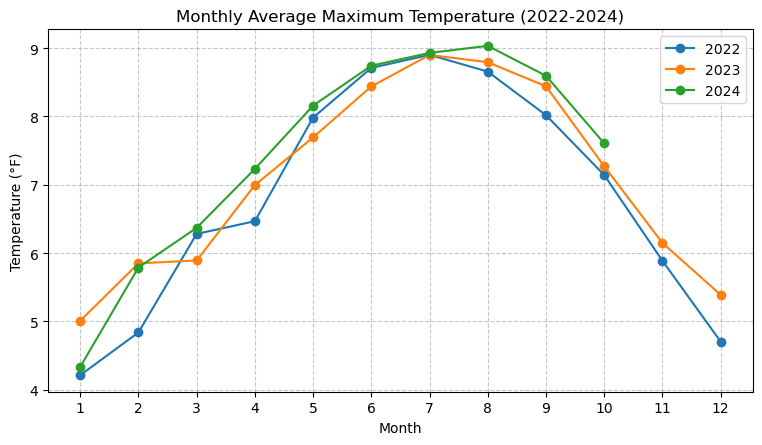

In [81]:
# Create visualizations
plt.figure(figsize=(20, 16))

# Monthly temperature patterns (2022-2024)
plt.subplot(3, 2, 1)
for year in monthly_max_stats_pd["YEAR"].unique():
    year_data = monthly_max_stats_pd[monthly_max_stats_pd["YEAR"] == year]
    plt.plot(year_data["MONTH"], year_data["AVG_MAX_TEMP"], marker='o', label=f"{int(year)}")
    
plt.title("Monthly Average Maximum Temperature (2022-2024)")
plt.xlabel("Month")
plt.ylabel("Temperature (°F)")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


([0, 1, 2, 3],
 [Text(0, 0, '2022-November'),
  Text(1, 0, '2023-November'),
  Text(2, 0, '2022-December'),
  Text(3, 0, '2023-December')])

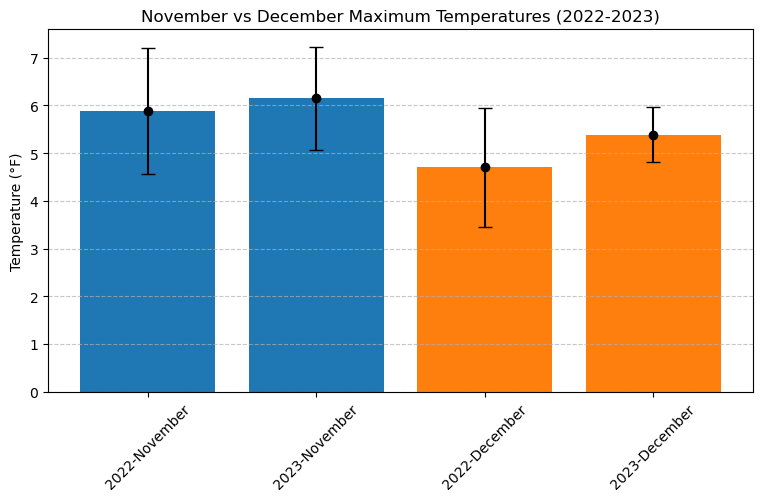

In [107]:
# Create visualizations
plt.figure(figsize=(20, 16))

# November-December MAX temperature comparison
plt.subplot(3, 2, 3)
month_names = {11: "November", 12: "December"}
for month in [11, 12]:
    month_data = nov_dec_stats_pd[nov_dec_stats_pd["MONTH"] == month]
    years = month_data["YEAR"].tolist()
    temps = month_data["AVG_MAX_TEMP"].tolist()
    
    x_pos = range(len(years))
    bars = plt.bar([str(year) + "-" + month_names[month] for year in years], temps, label=month_names[month])
    
    # Add error bars
    plt.errorbar(
        [str(year) + "-" + month_names[month] for year in years], 
        temps, 
        yerr=month_data["STDDEV_MAX"], 
        fmt='o', 
        color='black', 
        capsize=5
    )

plt.title("November vs December Maximum Temperatures (2022-2023)")
plt.ylabel("Temperature (°F)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

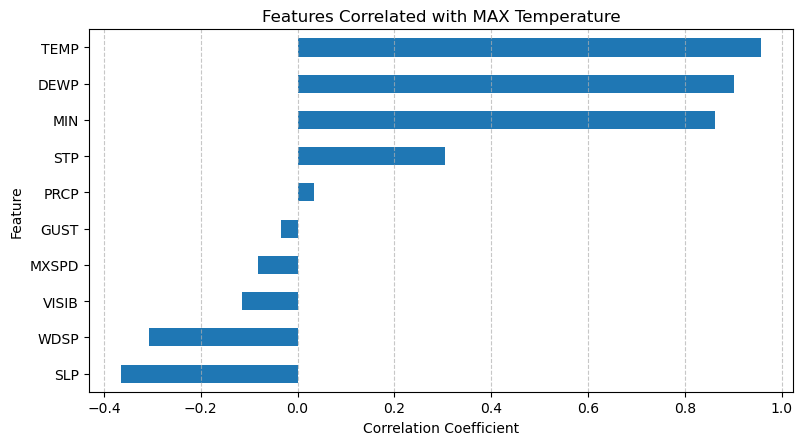

In [109]:
# Create visualizations
plt.figure(figsize=(20, 16))

# Correlation with MAX temperature
plt.subplot(3, 2, 4)
ax = plt.gca() 
correlation_df.sort_values("Correlation_with_MAX").plot(kind='barh', x="Feature", y="Correlation_with_MAX", legend=False, ax=ax)
plt.title("Features Correlated with MAX Temperature")
plt.xlabel("Correlation Coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.7)

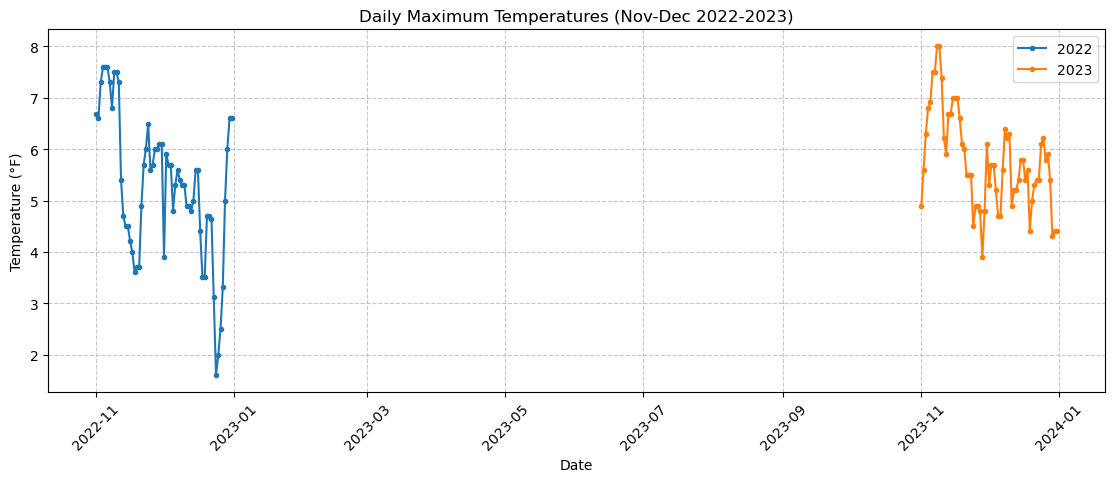

In [111]:
# Create visualizations
plt.figure(figsize=(30, 16))

# Daily MAX temperature values for Nov-Dec
plt.subplot(3, 2, 5)
for year in daily_max_temp["DATE"].dt.year.unique():
    year_data = daily_max_temp[daily_max_temp["DATE"].dt.year == year]
    plt.plot(year_data["DATE"], year_data["MAX"], marker='o', linestyle='-', markersize=3, label=str(year))

plt.title("Daily Maximum Temperatures (Nov-Dec 2022-2023)")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

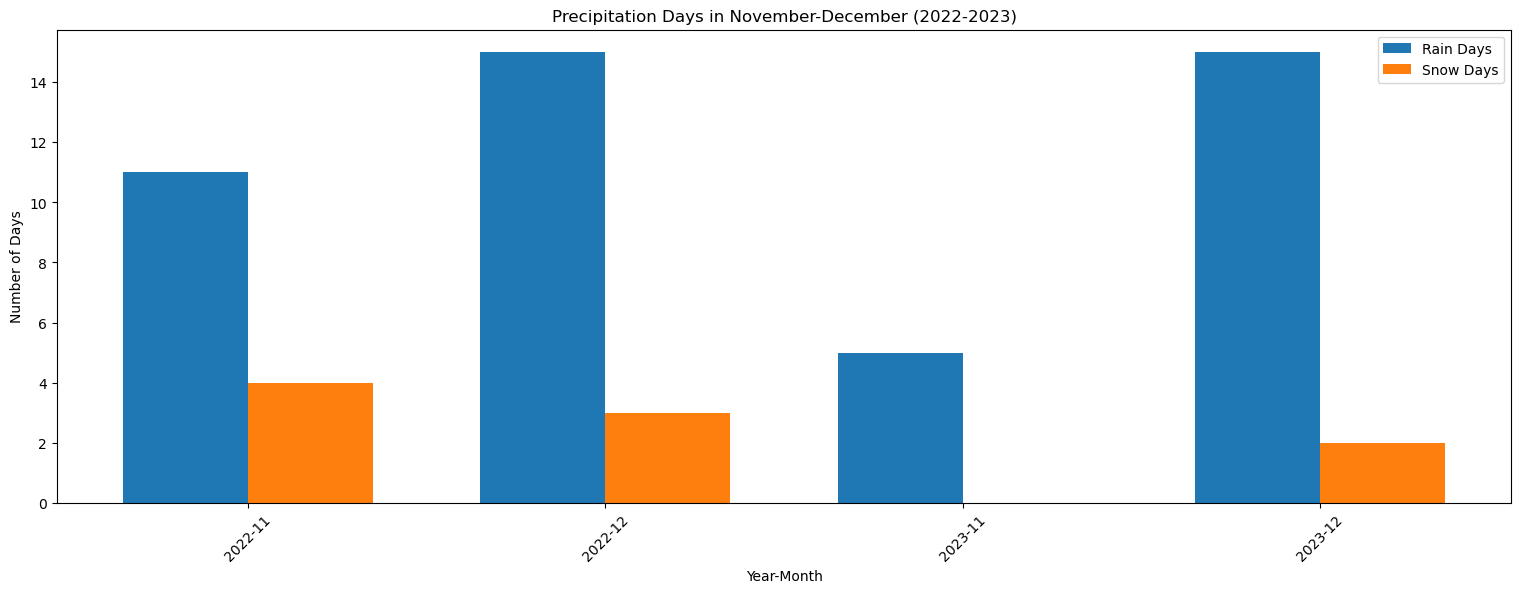

In [113]:
# Create visualizations
plt.figure(figsize=(30, 16))

# Weather conditions in Nov-Dec
plt.subplot(3, 2, 6)
if len(weather_conditions_pd) > 0:
    # Create x-axis labels
    x_labels = [f"{int(row['YEAR'])}-{int(row['MONTH'])}" for _, row in weather_conditions_pd.iterrows()]
    x = range(len(x_labels))
    width = 0.35
    
    rain_days = weather_conditions_pd["RAIN_DAYS"].tolist()
    snow_days = weather_conditions_pd["SNOW_DAYS"].tolist()
    
    plt.bar(x, rain_days, width, label='Rain Days')
    plt.bar([i + width for i in x], snow_days, width, label='Snow Days')
    
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Days')
    plt.title('Precipitation Days in November-December (2022-2023)')
    plt.xticks([i + width/2 for i in x], x_labels, rotation=45)
    plt.legend()
else:
    plt.text(0.5, 0.5, "Weather condition data not available", 
             horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.savefig("cincinnati_weather_eda_final.png")
plt.show()


In [115]:
# Detailed statistics for Nov-Dec
print("\nNovember-December MAX Temperature Statistics (2022-2023):")
print(nov_dec_stats_pd)

# Calculate year-over-year changes for November and December
nov_stats = nov_dec_stats_pd[nov_dec_stats_pd["MONTH"] == 11].sort_values("YEAR")
dec_stats = nov_dec_stats_pd[nov_dec_stats_pd["MONTH"] == 12].sort_values("YEAR")

if len(nov_stats) >= 2:
    print("\nNovember Year-over-Year Changes:")
    for i in range(1, len(nov_stats)):
        year_change = nov_stats.iloc[i]["YEAR"] - nov_stats.iloc[i-1]["YEAR"]
        temp_change = nov_stats.iloc[i]["AVG_MAX_TEMP"] - nov_stats.iloc[i-1]["AVG_MAX_TEMP"]
        high_change = nov_stats.iloc[i]["HIGHEST_MAX"] - nov_stats.iloc[i-1]["HIGHEST_MAX"]
        low_change = nov_stats.iloc[i]["LOWEST_MAX"] - nov_stats.iloc[i-1]["LOWEST_MAX"]
        print(f"From {int(nov_stats.iloc[i-1]['YEAR'])} to {int(nov_stats.iloc[i]['YEAR'])}:")
        print(f"  Average MAX: {temp_change:.2f}°F")
        print(f"  Highest MAX: {high_change:.2f}°F")
        print(f"  Lowest MAX: {low_change:.2f}°F")

if len(dec_stats) >= 2:
    print("\nDecember Year-over-Year Changes:")
    for i in range(1, len(dec_stats)):
        year_change = dec_stats.iloc[i]["YEAR"] - dec_stats.iloc[i-1]["YEAR"]
        temp_change = dec_stats.iloc[i]["AVG_MAX_TEMP"] - dec_stats.iloc[i-1]["AVG_MAX_TEMP"]
        high_change = dec_stats.iloc[i]["HIGHEST_MAX"] - dec_stats.iloc[i-1]["HIGHEST_MAX"]
        low_change = dec_stats.iloc[i]["LOWEST_MAX"] - dec_stats.iloc[i-1]["LOWEST_MAX"]
        print(f"From {int(dec_stats.iloc[i-1]['YEAR'])} to {int(dec_stats.iloc[i]['YEAR'])}:")
        print(f"  Average MAX: {temp_change:.2f}°F")
        print(f"  Highest MAX: {high_change:.2f}°F")
        print(f"  Lowest MAX: {low_change:.2f}°F")

# Data insights summary
print("\n----- Key Insights -----")

print("\n1. November MAX Temperature:")
if len(nov_stats) > 0:
    print(f"   - 2022 Average: {nov_stats[nov_stats['YEAR']==2022]['AVG_MAX_TEMP'].values[0]:.2f}°F")
    print(f"   - 2023 Average: {nov_stats[nov_stats['YEAR']==2023]['AVG_MAX_TEMP'].values[0]:.2f}°F")
    if len(nov_stats) >= 2:
        trend = nov_stats.iloc[1]["AVG_MAX_TEMP"] - nov_stats.iloc[0]["AVG_MAX_TEMP"]
        print(f"   - Trend: {'Increasing' if trend > 0 else 'Decreasing'} by {abs(trend):.2f}°F per year")

print("\n2. December MAX Temperature:")
if len(dec_stats) > 0:
    print(f"   - 2022 Average: {dec_stats[dec_stats['YEAR']==2022]['AVG_MAX_TEMP'].values[0]:.2f}°F")
    print(f"   - 2023 Average: {dec_stats[dec_stats['YEAR']==2023]['AVG_MAX_TEMP'].values[0]:.2f}°F")
    if len(dec_stats) >= 2:
        trend = dec_stats.iloc[1]["AVG_MAX_TEMP"] - dec_stats.iloc[0]["AVG_MAX_TEMP"]
        print(f"   - Trend: {'Increasing' if trend > 0 else 'Decreasing'} by {abs(trend):.2f}°F per year")

print("\n3. Key Feature Correlations with MAX Temperature:")
for _, row in correlation_df.head(3).iterrows():
    print(f"   - {row['Feature']}: {row['Correlation_with_MAX']:.4f}")

print("\n4. Weather Patterns:")
if len(weather_conditions_pd) > 0:
    nov_weather = weather_conditions_pd[weather_conditions_pd["MONTH"] == 11]
    dec_weather = weather_conditions_pd[weather_conditions_pd["MONTH"] == 12]
    
    print("   November:")
    print(f"   - Average Rain Days: {nov_weather['RAIN_DAYS'].mean():.1f}")
    print(f"   - Average Snow Days: {nov_weather['SNOW_DAYS'].mean():.1f}")
    
    print("   December:")
    print(f"   - Average Rain Days: {dec_weather['RAIN_DAYS'].mean():.1f}")
    print(f"   - Average Snow Days: {dec_weather['SNOW_DAYS'].mean():.1f}")


November-December MAX Temperature Statistics (2022-2023):
   YEAR  MONTH  AVG_MAX_TEMP  HIGHEST_MAX  LOWEST_MAX  STDDEV_MAX  \
0  2022     11      5.888333         7.59         3.6    1.316437   
1  2022     12      4.705161         6.60         1.6    1.243822   
2  2023     11      6.149333         8.01         3.9    1.081860   
3  2023     12      5.390000         6.40         4.3    0.585446   

   OBSERVATION_COUNT  
0                 30  
1                 31  
2                 30  
3                 31  

November Year-over-Year Changes:
From 2022 to 2023:
  Average MAX: 0.26°F
  Highest MAX: 0.42°F
  Lowest MAX: 0.30°F

December Year-over-Year Changes:
From 2022 to 2023:
  Average MAX: 0.68°F
  Highest MAX: -0.20°F
  Lowest MAX: 2.70°F

----- Key Insights -----

1. November MAX Temperature:
   - 2022 Average: 5.89°F
   - 2023 Average: 6.15°F
   - Trend: Increasing by 0.26°F per year

2. December MAX Temperature:
   - 2022 Average: 4.71°F
   - 2023 Average: 5.39°F
   - Trend:

In [119]:
# List of string columns that need to be converted to double
string_cols_to_convert = ["TEMP", "DEWP", "VISIB", "WDSP", "MIN"]

# Convert string columns to double
for col_name in string_cols_to_convert:
    nov_dec_data = nov_dec_data.withColumn(col_name, col(col_name).cast(DoubleType()))

## Predict the maximum Temperature for Cincinnati for November and December 2024, based on the previous 2 years of weather data

## Model Used - SARIMA

In [73]:
import pandas as pd
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when, expr
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
from typing import Tuple, List
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from pyspark.sql import functions as F
from pyspark.sql.functions import col

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from pyspark.sql import functions as F
from pyspark.sql.functions import col

def load_data() -> DataFrame:
    """
    Load and combine all Cincinnati weather data (2015-2024) into one dataframe

    Returns:
        all_df: The DataFrame containing all historical Cincinnati weather data.
    """
    years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
    base_file_dir = "Data"
    file_name_cincinnati = "72429793812.csv"
    
    all_df = None  # Initialize all_df to None
    
    for year in years:
        try:
            file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
            csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)
    
            if all_df is None:  # First year, initialize all_df
                all_df = csv_df_cincinnati
            else:  # Subsequent years, union the data
                all_df = all_df.union(csv_df_cincinnati)
    
        except Exception as e:
            print(f"Error processing data for {year}: {e}")
    
    return all_df

def preprocess_data(all_df) -> DataFrame:
    """
    Perform preprocessing on the input DataFrame.

    Args:
        all_df: The input DataFrame with all past data (2015-2024).

    Returns:
        all_df_preprocessed: The preprocessed DataFrame with all past data (2015-2024).
    """
    
    # Handle missing values as per the data description
    missing_value_replacements = {
        "TEMP": 9999.9, 
        "DEWP": 9999.9, 
        "SLP": 9999.9, 
        "STP": 9999.9, 
        "VISIB": 999.9, 
        "WDSP": 999.9, 
        "MXSPD": 999.9, 
        "GUST": 999.9, 
        "MAX": 9999.9, 
        "MIN": 9999.9, 
        "PRCP": 99.99, 
        "SNDP": 999.9
    }
    
    # Replace missing values with nulls for proper handling
    for column, missing_val in missing_value_replacements.items():
        if column in all_df.columns:
            all_df = all_df.withColumn(
                column, 
                F.when(col(column) == missing_val, None).otherwise(col(column))
            )
    
    # Drop SNDP column since 100% data is missing
    all_df = all_df.drop("SNDP")
    
    # Convert pyspark dataframe to pandas.
    pandas_df = all_df.toPandas()
    
    # Convert to numeric, handling errors
    pandas_df['GUST'] = pd.to_numeric(pandas_df['GUST'], errors='coerce')
    pandas_df['PRCP'] = pd.to_numeric(pandas_df['PRCP'], errors='coerce')
    pandas_df['STP'] = pd.to_numeric(pandas_df['STP'], errors='coerce')
    pandas_df['SLP'] = pd.to_numeric(pandas_df['SLP'], errors='coerce')
    pandas_df['MXSPD'] = pd.to_numeric(pandas_df['MXSPD'], errors='coerce')
    pandas_df['MAX'] = pd.to_numeric(pandas_df['MAX'], errors='coerce')
    
    # Impute missing values for columns using linear interpolation
    pandas_df['GUST'] = pandas_df['GUST'].interpolate(method='linear')
    pandas_df['PRCP'] = pandas_df['PRCP'].interpolate(method='linear')
    pandas_df['STP'] = pandas_df['STP'].interpolate(method='linear')
    pandas_df['SLP'] = pandas_df['SLP'].interpolate(method='linear')
    pandas_df['MXSPD'] = pandas_df['MXSPD'].interpolate(method='linear')
    pandas_df['MAX'] = pandas_df['MAX'].interpolate(method='linear')

    # Convert DATE column to datetime format if it's not already
    if 'DATE' in pandas_df.columns:
        pandas_df['DATE'] = pd.to_datetime(pandas_df['DATE'])

    all_df = spark.createDataFrame(pandas_df)

    # List of string columns that need to be converted to double
    string_cols_to_convert = ["TEMP", "DEWP", "VISIB", "WDSP", "MIN"]
    
    # Convert string columns to double
    for col_name in string_cols_to_convert:
        all_df = all_df.withColumn(col_name, col(col_name).cast(DoubleType()))

    # Add Day, month, year columns for time-based analysis
    all_df_preprocessed = all_df.withColumn("MONTH", F.month(F.col("DATE"))) \
                                .withColumn("YEAR", F.year(F.col("DATE"))) \
                                .withColumn("DAY", F.day(F.col("DATE")))

    return all_df_preprocessed

def feature_engineering(all_df_preprocessed) -> Tuple[DataFrame, DataFrame, List[str]]:
    """
    Perform feature engineering on the input DataFrame.

    Args:
        all_df_preprocessed: The input DataFrame with all cleaned data.

    Returns:
        enriched_df: The DataFrame with engineered features for all past data.
        nov_dec_df: The DataFrame with engineered features for November and December of past 2 years data.
        feature_cols: List of all the feature columns.
    """
        
    # Parse FRSHTT column to extract weather condition indicators
    if "FRSHTT" in all_df_preprocessed.columns:
        all_df_preprocessed = all_df_preprocessed.withColumn("FOG", F.substring("FRSHTT", 1, 1)) \
                                             .withColumn("RAIN", F.substring("FRSHTT", 2, 1)) \
                                             .withColumn("SNOW", F.substring("FRSHTT", 3, 1)) \
                                             .withColumn("HAIL", F.substring("FRSHTT", 4, 1)) \
                                             .withColumn("THUNDER", F.substring("FRSHTT", 5, 1)) \
                                             .withColumn("TORNADO", F.substring("FRSHTT", 6, 1))
        
        # Convert weather condition flags to numeric
        for flag in ["FOG", "RAIN", "SNOW", "HAIL", "THUNDER", "TORNADO"]:
            all_df_preprocessed = all_df_preprocessed.withColumn(flag, col(flag).cast(DoubleType()))
            
    # Define base feature columns
    base_feature_cols = [
        "TEMP", "DEWP", "MIN", "SLP", "STP", "VISIB", "WDSP", "MXSPD", "GUST", "PRCP",
        "FOG", "RAIN", "SNOW", "HAIL", "THUNDER", "MONTH", "YEAR", "DAY"
    ]
    
    # Create derived features
    enriched_df = all_df_preprocessed.withColumn("TEMP_RANGE", col("MAX") - col("MIN"))
    
    # Fix: Ensure we're using the updated DataFrame with TEMP_RANGE for subsequent operations
    enriched_df = enriched_df.withColumn("DEWP_DIFF", col("TEMP") - col("DEWP"))
    
    # Calculate humidity indicator 
    enriched_df = enriched_df.withColumn(
        "HUMID_INDICATOR", 
        F.when(col("TEMP") != 0, col("DEWP") / col("TEMP")).otherwise(None)
    )
    
    # Calculate pressure difference
    enriched_df = enriched_df.withColumn(
        "PRESSURE_DIFF", 
        F.when(col("SLP").isNotNull() & col("STP").isNotNull(), col("SLP") - col("STP")).otherwise(None)
    )
    
    # Add day of year feature for seasonal patterns
    if "DATE" in enriched_df.columns:
        enriched_df = enriched_df.withColumn("DAY_OF_YEAR", F.dayofyear(F.col("DATE")))
        # Add derived feature columns list
        derived_features = ["TEMP_RANGE", "DEWP_DIFF", "HUMID_INDICATOR", "PRESSURE_DIFF", "DAY_OF_YEAR"]
    else:
        # Add derived feature columns list without date-dependent features
        derived_features = ["TEMP_RANGE", "DEWP_DIFF", "HUMID_INDICATOR", "PRESSURE_DIFF"]

    # Select only the features that exist and have valid data
    feature_cols = []
    for feature in base_feature_cols + derived_features:
        if feature in enriched_df.columns:
            feature_cols.append(feature)
   
    # Create logger variable if it doesn't exist
    import logging
    logger = logging.getLogger(__name__)
    logger.info(f"Using features: {feature_cols}")

    # Create new dataframe by filtering data from past two years
    past_2year_df = enriched_df.filter(
        (col("DATE") >= "2022-01-01") & 
        (col("DATE") < "2024-11-01")
    )

    # Create new dataframe by filtering data from November and December of past two years
    nov_dec_df = past_2year_df.filter((col("MONTH") == 11) | (col("MONTH") == 12))
    
    return enriched_df, past_2year_df, nov_dec_df, feature_cols

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def forecast_max_temperatures(nov_dec_df, past_2year_df, nov_dec_2024_df, target_year=2024):
    """
    Forecast maximum temperatures for November and December of the target year
    using SARIMA and simpler approaches.
    """
    logger.info(f"Starting temperature forecasting for {target_year}")

    # Convert PySpark DataFrame to Pandas
    df_pandas = nov_dec_df.toPandas()
    df_train = df_pandas.copy()

    # Ensure DATE is datetime
    if 'DATE' in df_train.columns and not pd.api.types.is_datetime64_dtype(df_train['DATE']):
        df_train['DATE'] = pd.to_datetime(df_train['DATE'])

    # Data statistics for logging
    logger.info(f"Training data statistics for MAX temperature:")
    logger.info(f"Mean: {df_train['MAX'].mean():.2f}, Min: {df_train['MAX'].min():.2f}, Max: {df_train['MAX'].max():.2f}")

    # Sort by date
    df_train = df_train.sort_values(by='DATE')

    # Extract monthly maximum temperatures for November and December
    nov_data = df_train[df_train['DATE'].dt.month == 11]
    dec_data = df_train[df_train['DATE'].dt.month == 12]

    # Calculate maximum temperature by month and year
    nov_yearly_max = nov_data.groupby(nov_data['DATE'].dt.year)['MAX'].max()
    dec_yearly_max = dec_data.groupby(dec_data['DATE'].dt.year)['MAX'].max()

    logger.info(f"November MAX temperatures by year: {nov_yearly_max.to_dict()}")
    logger.info(f"December MAX temperatures by year: {dec_yearly_max.to_dict()}")

    # Approach 1: Average of historical maximum temperatures
    nov_avg_prediction = nov_yearly_max.mean()
    dec_avg_prediction = dec_yearly_max.mean()

    # Approach 2: Last value + trend (of last 2 years)
    nov_trend_prediction = None
    dec_trend_prediction = None

    if len(nov_yearly_max) >= 2:
        nov_trend = nov_yearly_max.iloc[-1] - nov_yearly_max.iloc[-2]
        nov_trend_prediction = nov_yearly_max.iloc[-1] + nov_trend

    if len(dec_yearly_max) >= 2:
        dec_trend = dec_yearly_max.iloc[-1] - dec_yearly_max.iloc[-2]
        dec_trend_prediction = dec_yearly_max.iloc[-1] + dec_trend

    # Approach 3: Weighted average (recent years have more weight)
    if len(nov_yearly_max) >= 2:
        weights = np.arange(1, len(nov_yearly_max) + 1)
        nov_weighted_prediction = np.average(nov_yearly_max, weights=weights)
        dec_weighted_prediction = np.average(dec_yearly_max, weights=weights)
    else:
        nov_weighted_prediction = nov_avg_prediction
        dec_weighted_prediction = dec_avg_prediction

    # Approach 4: SARIMA model with monthly data
    df_train_including2024 = past_2year_df.toPandas()
    nov_sarima_pred = None
    dec_sarima_pred = None
    nov_sarima_ci = None
    dec_sarima_ci = None

    try:
        # Create time series for all MAX temperatures
        df_time_series = df_train_including2024[['DATE', 'MAX']].copy()
        df_time_series.set_index('DATE', inplace=True)
        
        # Resample to monthly data
        monthly_max = df_time_series.resample('ME').max()
        
        # Fit SARIMA model
        logger.info("Fitting SARIMA model with auto_arima...")
        
        # Use auto_arima with appropriate parameters
        model = pm.auto_arima(
            monthly_max,
            seasonal=True,
            m=12,  # Monthly data with yearly seasonality
            start_p=0, start_q=0,
            max_p=2, max_q=2,
            d=0, max_d=1,
            D=0, max_D=1,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            information_criterion='aic'
        )
        
        # Get model summary
        logger.info(f"SARIMA model order: {model.order}, seasonal order: {model.seasonal_order}")
        logger.info(f"AIC: {model.aic()}")

        try:
            # Forecast both November and December
            last_date = monthly_max.index[-1]
            months_to_forecast = 2
            forecast, conf_int = model.predict(n_periods=months_to_forecast, return_conf_int=True)
        
            # Create future dates
            future_dates = pd.date_range(
                start=last_date + pd.DateOffset(months=1),
                periods=months_to_forecast,
                freq='ME'
            )
        
            # Create forecast DataFrame
            forecast_df = pd.DataFrame({
                'Predicted_MAX': forecast,
                'Lower_CI': conf_int[:, 0],
                'Upper_CI': conf_int[:, 1]
            }, index=future_dates)
            
            # Extract November and December forecasts
            nov_idx = (forecast_df.index.month == 11) & (forecast_df.index.year == target_year)
            dec_idx = (forecast_df.index.month == 12) & (forecast_df.index.year == target_year)
        
            if len(forecast_df[nov_idx]) > 0:
                nov_sarima = forecast_df[nov_idx]['Predicted_MAX']
                nov_sarima_ci = (forecast_df[nov_idx]['Upper_CI'] - forecast_df[nov_idx]['Lower_CI']) / 2
                nov_sarima_pred = float(nov_sarima.iloc[0])
                nov_sarima_ci = float(nov_sarima_ci.iloc[0])
        
            if len(forecast_df[dec_idx]) > 0:
                dec_sarima = forecast_df[dec_idx]['Predicted_MAX']
                dec_sarima_ci = (forecast_df[dec_idx]['Upper_CI'] - forecast_df[dec_idx]['Lower_CI']) / 2
                dec_sarima_pred = float(dec_sarima.iloc[0])
                dec_sarima_ci = float(dec_sarima_ci.iloc[0])
        
        except Exception as e:
            logger.error(f"Error in SARIMA forecasting: {str(e)}")
            logger.exception("SARIMA forecast error details:")
            nov_sarima_pred = None
            dec_sarima_pred = None
            nov_sarima_ci = None
            dec_sarima_ci = None
        
        # Check for reasonableness
        if nov_sarima_pred is not None and (nov_sarima_pred < -30 or nov_sarima_pred > 120):
            logger.warning(f"SARIMA November prediction {nov_sarima_pred}°F seems unreasonable. Falling back to simpler methods.")
            nov_sarima_pred = None
        
        if dec_sarima_pred is not None and (dec_sarima_pred < -30 or dec_sarima_pred > 120):
            logger.warning(f"SARIMA December prediction {dec_sarima_pred}°F seems unreasonable. Falling back to simpler methods.")
            dec_sarima_pred = None

        
    except Exception as e:
        logger.error(f"Error in SARIMA modeling: {str(e)}")
        nov_sarima_pred = None
        dec_sarima_pred = None
        nov_sarima_ci = None
        dec_sarima_ci = None
    
    # Determine final predictions using all methods
    # If SARIMA works, use it; otherwise, use weighted average
    nov_prediction = nov_sarima_pred if nov_sarima_pred is not None else nov_weighted_prediction
    dec_prediction = dec_sarima_pred if dec_sarima_pred is not None else dec_weighted_prediction
    
    # Confidence intervals - use SARIMA if available or calculate from historical data
    if nov_sarima_ci is not None:
        nov_ci = nov_sarima_ci
    else:
        nov_ci = nov_yearly_max.std() * 1.96 if len(nov_yearly_max) > 1 else 5.0
        
    if dec_sarima_ci is not None:
        dec_ci = dec_sarima_ci
    else:
        dec_ci = dec_yearly_max.std() * 1.96 if len(dec_yearly_max) > 1 else 5.0
    
    # Store all results
    results = {
        'November': {
            'prediction': nov_prediction,
            'confidence_interval': nov_ci,
            'sarima_prediction': nov_sarima_pred,
            'avg_prediction': nov_avg_prediction,
            'trend_prediction': nov_trend_prediction,
            'weighted_prediction': nov_weighted_prediction,
            'historical_data': nov_yearly_max.to_dict()
        },
        'December': {
            'prediction': dec_prediction,
            'confidence_interval': dec_ci,
            'sarima_prediction': dec_sarima_pred,
            'avg_prediction': dec_avg_prediction,
            'trend_prediction': dec_trend_prediction,
            'weighted_prediction': dec_weighted_prediction,
            'historical_data': dec_yearly_max.to_dict()
        }
    }

    # Convert PySpark DataFrame to Pandas    
    nov_dec_2024_pandas = nov_dec_2024_df.toPandas() 
    # Evaluate with actual data
    nov_test = nov_dec_2024_pandas[nov_dec_2024_pandas['DATE'].dt.month == 11]
    dec_test = nov_dec_2024_pandas[nov_dec_2024_pandas['DATE'].dt.month == 12]
    
    if len(nov_test) > 0:
        actual_nov_max = nov_test['MAX'].max()
        results['November']['actual'] = actual_nov_max
        results['November']['error'] = abs(nov_prediction - actual_nov_max)
        logger.info(f"November {target_year} Actual MAX: {actual_nov_max}°F")
        logger.info(f"November {target_year} Prediction Error: {results['November']['error']:.2f}°F")
        
    if len(dec_test) > 0:
        actual_dec_max = dec_test['MAX'].max()
        results['December']['actual'] = actual_dec_max
        results['December']['error'] = abs(dec_prediction - actual_dec_max)
        logger.info(f"December {target_year} Actual MAX: {actual_dec_max}°F")
        logger.info(f"December {target_year} Prediction Error: {results['December']['error']:.2f}°F")
    
    
    # Print results table
    print("\n" + "="*120)
    print(f"TEMPERATURE PREDICTION RESULTS FOR {target_year}".center(120))
    print("="*120)
    
    # Define table headers and widths
    headers = [
        "Month", "Prediction", "Confidence Int.", "SARIMA", "Avg Method", 
        "Trend Method", "Weighted Avg", "Actual", "Error"
    ]
    widths = [10, 12, 15, 12, 12, 15, 12, 12, 12]
    
    # Print header row
    header_row = ""
    for header, width in zip(headers, widths):
        header_row += f"{header:^{width}}"
    print(header_row)
    
    # Print separator
    print("-"*120)
    
    # Print data rows
    for month in ['November', 'December']:
        row = f"{month:^{widths[0]}}"
        
        # Prediction
        if results[month]['prediction'] is not None:
            row += f"{results[month]['prediction']:.2f}°F".center(widths[1])
        else:
            row += "N/A".center(widths[1])
        
        # Confidence Interval
        if results[month]['confidence_interval'] is not None:
            row += f"±{results[month]['confidence_interval']:.2f}°F".center(widths[2])
        else:
            row += "N/A".center(widths[2])
        
        # SARIMA
        if results[month]['sarima_prediction'] is not None:
            row += f"{results[month]['sarima_prediction']:.2f}°F".center(widths[3])
        else:
            row += "N/A".center(widths[3])
        
        # Average Method
        if results[month]['avg_prediction'] is not None:
            row += f"{results[month]['avg_prediction']:.2f}°F".center(widths[4])
        else:
            row += "N/A".center(widths[4])
        
        # Trend Method
        if results[month]['trend_prediction'] is not None:
            row += f"{results[month]['trend_prediction']:.2f}°F".center(widths[5])
        else:
            row += "N/A".center(widths[5])
        
        # Weighted Average
        if results[month]['weighted_prediction'] is not None:
            row += f"{results[month]['weighted_prediction']:.2f}°F".center(widths[6])
        else:
            row += "N/A".center(widths[6])
        
        # Actual
        if 'actual' in results[month]:
            row += f"{results[month]['actual']:.2f}°F".center(widths[7])
        else:
            row += "Unknown".center(widths[7])
        
        # Error
        if 'error' in results[month]:
            row += f"{results[month]['error']:.2f}°F".center(widths[8])
        else:
            row += "N/A".center(widths[8])
        
        print(row)
    
    # Print bottom border
    print("="*120)
    
    return results


def main():
    # Load data 
    all_df = load_data()

    # Preprocess data 
    all_df_preprocessed = preprocess_data(all_df)
        
    # Perform Feature Engineering on November and December data
    enriched_df, past_2year_df, nov_dec_df, feature_cols = feature_engineering(all_df_preprocessed)
        
    # Create dataframe by filtering data from November and December of 2024
    nov_dec_2024_df = enriched_df.filter((F.col("YEAR") == 2024) & (F.col("MONTH").isin([11, 12])))   

    # Run forecasting
    forecast_max_temperatures(nov_dec_df, past_2year_df, nov_dec_2024_df, 2024)
    
if __name__ == "__main__":
    main()

2025-03-23 22:25:41,376 - __main__ - INFO - Using features: ['TEMP', 'DEWP', 'MIN', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'PRCP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 'THUNDER', 'MONTH', 'YEAR', 'DAY', 'TEMP_RANGE', 'DEWP_DIFF', 'HUMID_INDICATOR', 'PRESSURE_DIFF', 'DAY_OF_YEAR']
2025-03-23 22:25:41,400 - __main__ - INFO - Starting temperature forecasting for 2024
2025-03-23 22:25:41,755 - __main__ - INFO - Training data statistics for MAX temperature:
2025-03-23 22:25:41,755 - __main__ - INFO - Mean: 55.25, Min: 16.00, Max: 80.10
2025-03-23 22:25:41,761 - __main__ - INFO - November MAX temperatures by year: {2022: 75.9, 2023: 80.1}
2025-03-23 22:25:41,761 - __main__ - INFO - December MAX temperatures by year: {2022: 66.0, 2023: 64.0}
2025-03-23 22:25:41,933 - __main__ - INFO - Fitting SARIMA model with auto_arima...


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=264.735, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=400.051, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=233.208, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=224.586, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=207.433, Time=0.10 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=210.863, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 AR

2025-03-23 22:25:43,939 - __main__ - INFO - SARIMA model order: (2, 0, 0), seasonal order: (1, 0, 0, 12)
2025-03-23 22:25:43,940 - __main__ - INFO - AIC: 207.43288769777033
2025-03-23 22:25:44,085 - __main__ - INFO - November 2024 Actual MAX: 80.1°F
2025-03-23 22:25:44,085 - __main__ - INFO - November 2024 Prediction Error: 0.47°F
2025-03-23 22:25:44,086 - __main__ - INFO - December 2024 Actual MAX: 63.0°F
2025-03-23 22:25:44,092 - __main__ - INFO - December 2024 Prediction Error: 3.22°F


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=207.470, Time=0.11 sec
 ARIMA(2,0,0)(1,0,0)[12]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,0,0)(1,0,0)[12] intercept
Total fit time: 2.004 seconds

                                        TEMPERATURE PREDICTION RESULTS FOR 2024                                         
  Month    Prediction Confidence Int.   SARIMA    Avg Method  Trend Method  Weighted Avg   Actual      Error    
------------------------------------------------------------------------------------------------------------------------
 November   80.57°F       ±6.55°F      80.57°F     78.00°F       84.30°F      78.70°F     80.10°F      0.47°F   
 December   66.22°F       ±7.69°F      66.22°F     65.00°F       62.00°F      64.67°F     63.00°F      3.22°F   


## Predict the maximum Temperature for Cincinnati for November and December 2024, based on the previous 2 years of weather data

## Model Used - XGBoost

In [91]:
def load_data() -> DataFrame:
    """
    Load and combine all Cincinnati weather data (2015-2024) into one dataframe

    Returns:
        all_df: The DataFrame containing all historical Cincinnati weather data.
    """
    years = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
    base_file_dir = "Data"
    file_name_cincinnati = "72429793812.csv"
    
    all_df = None  # Initialize all_cincinnati_df to None
    
    for year in years:
        try:
            file_path_cincinnati = f"{base_file_dir}/{year}/{file_name_cincinnati}"
            csv_df_cincinnati = spark.read.option("header", "true").option("delimiter", ",").csv(file_path_cincinnati)
    
            if all_df is None:  # First year, initialize all_cincinnati_df
                all_df = csv_df_cincinnati
            else:  # Subsequent years, union the data
                all_df = all_df.union(csv_df_cincinnati)
    
        except Exception as e:
            print(f"Error processing data for {year}: {e}")
    
    return all_df
def preprocess_data(all_df) -> DataFrame:
    """
    Perform preprocessing on the input DataFrame.

    Args:
        df: The input DataFrame with all past data (2015-2024).

    Returns:
        all_df: The preprocessed DataFrame with all past data (2015-2024).
    """
    
    # Handle missing values as per the data description
    missing_value_replacements = {
        "TEMP": 9999.9, 
        "DEWP": 9999.9, 
        "SLP": 9999.9, 
        "STP": 9999.9, 
        "VISIB": 999.9, 
        "WDSP": 999.9, 
        "MXSPD": 999.9, 
        "GUST": 999.9, 
        "MAX": 9999.9, 
        "MIN": 9999.9, 
        "PRCP": 99.99, 
        "SNDP": 999.9
    }
    
    # Replace missing values with nulls for proper handling
    for column, missing_val in missing_value_replacements.items():
        if column in all_df.columns:
            all_df = all_df.withColumn(
                column, 
                F.when(col(column) == missing_val, None).otherwise(col(column))
            )
    
    # Drop SNDP column since 100% data is missing
    all_df = all_df.drop("SNDP")
    
    # Convert pyspark dataframe to pandas.
    pandas_df = all_df.toPandas()
    
    # Convert to numeric, handling errors
    pandas_df['GUST'] = pd.to_numeric(pandas_df['GUST'], errors='coerce')
    pandas_df['PRCP'] = pd.to_numeric(pandas_df['PRCP'], errors='coerce')
    pandas_df['STP'] = pd.to_numeric(pandas_df['STP'], errors='coerce')
    pandas_df['SLP'] = pd.to_numeric(pandas_df['SLP'], errors='coerce')
    pandas_df['MXSPD'] = pd.to_numeric(pandas_df['MXSPD'], errors='coerce')
    pandas_df['MAX'] = pd.to_numeric(pandas_df['MAX'], errors='coerce')
    
    # Impute missing values for columns using linear interpolation
    pandas_df['GUST'] = pandas_df['GUST'].interpolate(method='linear')
    pandas_df['PRCP'] = pandas_df['PRCP'].interpolate(method='linear')
    pandas_df['STP'] = pandas_df['STP'].interpolate(method='linear')
    pandas_df['SLP'] = pandas_df['SLP'].interpolate(method='linear')
    pandas_df['MXSPD'] = pandas_df['MXSPD'].interpolate(method='linear')
    pandas_df['MAX'] = pandas_df['MAX'].interpolate(method='linear')

    all_df = spark.createDataFrame(pandas_df)

    # List of string columns that need to be converted to double
    string_cols_to_convert = ["TEMP", "DEWP", "VISIB", "WDSP", "MIN"]
    
    # Convert string columns to double
    for col_name in string_cols_to_convert:
        all_df = all_df.withColumn(col_name, col(col_name).cast(DoubleType()))

    # Add Day, month, year columns for time-based analysis
    all_df_preprocessed = all_df.withColumn("MONTH", F.month(F.col("DATE"))) \
                                                    .withColumn("YEAR", F.year(F.col("DATE"))) \
                                                    .withColumn("DAY", F.day(F.col("DATE")))

    return all_df_preprocessed
def feature_engineering(all_df_preprocessed) -> Tuple[DataFrame, DataFrame, List[str]]:
    """
    Perform feature engineering on the input DataFrame.

    Args:
        all_df_preprocessed: The input DataFrame with all cleaned data.

    Returns:
        enriched_df: The DataFrame with engineered features for all past data.
        nov_dec_df: The DataFrame with engineered features for November and December of past 2 years data.
        feature_cols: List of all the feature columns.
    """
        
    # Parse FRSHTT column to extract weather condition indicators
    if "FRSHTT" in all_df_preprocessed.columns:
        all_df_preprocessed = all_df_preprocessed.withColumn("FOG", F.substring("FRSHTT", 1, 1)) \
                                             .withColumn("RAIN", F.substring("FRSHTT", 2, 1)) \
                                             .withColumn("SNOW", F.substring("FRSHTT", 3, 1)) \
                                             .withColumn("HAIL", F.substring("FRSHTT", 4, 1)) \
                                             .withColumn("THUNDER", F.substring("FRSHTT", 5, 1)) \
                                             .withColumn("TORNADO", F.substring("FRSHTT", 6, 1))
        
        # Convert weather condition flags to numeric
        for flag in ["FOG", "RAIN", "SNOW", "HAIL", "THUNDER", "TORNADO"]:
            all_df_preprocessed = all_df_preprocessed.withColumn(flag, col(flag).cast(DoubleType()))
            
    # Define base feature columns
    base_feature_cols = [
        "TEMP", "DEWP", "MIN", "SLP", "STP", "VISIB", "WDSP", "MXSPD", "GUST", "PRCP",
        "FOG", "RAIN", "SNOW", "HAIL", "THUNDER", "MONTH", "YEAR", "DAY"
    ]
    
    # Create derived features
    enriched_df = all_df_preprocessed.withColumn("TEMP_RANGE", col("MAX") - col("MIN"))
    enriched_df = all_df_preprocessed.withColumn("DEWP_DIFF", col("TEMP") - col("DEWP"))
    
    # Calculate humidity indicator 
    enriched_df = enriched_df.withColumn(
        "HUMID_INDICATOR", 
        when(col("TEMP") != 0, col("DEWP") / col("TEMP")).otherwise(None)
    )
    
    # Calculate pressure difference
    enriched_df = enriched_df.withColumn(
        "PRESSURE_DIFF", 
        when(col("SLP").isNotNull() & col("STP").isNotNull(), col("SLP") - col("STP")).otherwise(None)
    )
    
    # Add day of year feature for seasonal patterns
    if "DATE" in enriched_df.columns:
        enriched_df = enriched_df.withColumn("DAY_OF_YEAR", expr("dayofyear(DATE)"))
        # Add derived feature columns list
        derived_features = ["TEMP_RANGE", "DEWP_DIFF", "HUMID_INDICATOR", "PRESSURE_DIFF", "DAY_OF_YEAR"]
    else:
        # Add derived feature columns list without date-dependent features
        derived_features = ["TEMP_RANGE", "DEWP_DIFF", "HUMID_INDICATOR", "PRESSURE_DIFF"]

    # Select only the features that exist and have valid data
    feature_cols = []
    for feature in base_feature_cols + derived_features:
        if feature in enriched_df.columns:
            feature_cols.append(feature)
   
    logger.info(f"Using features: {feature_cols}")

    # Create new dataframe by filtering data from past two years
    past_2year_df = enriched_df.filter(
        (col("DATE") >= "2022-01-01") & 
        (col("DATE") < "2024-11-01")
    )

    # Create new dataframe by filtering data from November and December of past two years
    nov_dec_df = past_2year_df.filter((col("MONTH") == 11) | (col("MONTH") == 12))
    
    return enriched_df, nov_dec_df, feature_cols

def build_model_pipeline(feature_cols, label_col="MAX"):
    """
    Build model pipeline with feature preprocessing and XGBoost model

    Args:
        feature_cols: A list of feature column names.
        label_col: The name of the label column.

    Returns:
        A Spark ML Pipeline.
    """
    
    # Create vector assembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features", handleInvalid="skip")

    # Add feature scaling
    scaler = StandardScaler(inputCol="raw_features", outputCol="features",
                          withStd=True, withMean=True)

    # Define XGBoost parameters 
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col=label_col,
        missing=float('nan'),  # Handle missing values
        max_depth=6,           
        learning_rate=0.05,    
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        num_workers=1,         # Number of workers
        tree_method="auto",    # Let XGBoost choose the best tree method
        objective="reg:squarederror",
        num_round=200,
        seed=42
    )

    # Create and return the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, xgb])
    
    return pipeline

def train_and_evaluate_model(month_data, predict_year, feature_cols, month_name):
    """
    Train model on available years (2022-2023) and predict for a target year (2024)
    
    Parameters:
    month_data (DataFrame): Filtered data for a specific month
    predict_year (int): Year to predict for (e.g., 2024)
    feature_cols (list): List of feature column names
    month_name (str): Name of month for logging
    
    Returns:
    dict: Training results and prediction
    """
    logger.info(f"Training model for {month_name} using all available data")

    # Filter training data - all years before predict_year
    train_data = month_data.filter(col("YEAR") < predict_year)

    train_count = train_data.count()
    
    # Get available years for logging
    available_years = [row["YEAR"] for row in train_data.select("YEAR").distinct().collect()]
    logger.info(f"Training on data from years: {available_years}")
    
    # Build model pipeline
    pipeline = build_model_pipeline(feature_cols)
    
    # Split data into training and validation sets (80/20 split)
    train_df, val_df = train_data.randomSplit([0.8, 0.2], seed=42)
    
    # Set up parameter grid for tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(pipeline.getStages()[-1].max_depth, [6, 8]) \
        .addGrid(pipeline.getStages()[-1].learning_rate, [0.05, 0.1]) \
        .addGrid(pipeline.getStages()[-1].min_child_weight, [1, 3]) \
        .build()
    
    # Set up cross-validator
    evaluator = RegressionEvaluator(labelCol="MAX", predictionCol="prediction", metricName="rmse")
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3,
        parallelism=1
    )
    
    try:
        # Fit the model with cross-validation
        logger.info("Training with cross-validation")
        cv_model = cv.fit(train_df)
        
        # Get the best model
        best_pipeline = cv_model.bestModel
        
        # Define a path to save the model
        model_path = f"models/{month_name.lower()}_{predict_year}_model"
        
        # Save the model
        try:
            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(model_path), exist_ok=True)
            
            # Save the model
            best_pipeline.write().overwrite().save(model_path)
            logger.info(f"Model saved successfully to {model_path}")
            
        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
        
        # Evaluate on validation data
        val_predictions = best_pipeline.transform(val_df)
        val_rmse = evaluator.evaluate(val_predictions)
        logger.info(f"Validation RMSE: {val_rmse:.2f}")
        
        # Prepare prediction data for target year
        # Use average values from all training data 
        avg_expressions = [F.avg(col(feature)).alias(feature) for feature in feature_cols]
        training_avg = train_data.select(avg_expressions).collect()[0]
        
        # Create prediction dataframe
        prediction_data = {feature: float(training_avg[feature]) for feature in feature_cols}
        prediction_data["YEAR"] = predict_year
        prediction_df = spark.createDataFrame([prediction_data])
        
        # Get prediction using the best pipeline
        prediction_result = best_pipeline.transform(prediction_df).select("prediction").collect()[0][0]
        
        # Calculate confidence interval based on historical variance
        stddev_value = train_data.select(F.stddev("MAX")).collect()[0][0]
        if stddev_value is not None:
            stddev_value = float(stddev_value)
            confidence_interval = 1.96 * stddev_value / (train_count ** 0.5)  # 95% confidence interval
        else:
            confidence_interval = 0
            logger.warning("Could not calculate standard deviation, confidence interval set to 0")
        
        # Return results
        return {
            "prediction": prediction_result,
            "confidence_interval": confidence_interval,
            "validation_rmse": val_rmse,
            "model_path": model_path,
            "training_years": available_years
        }
    
    except Exception as e:
        logger.error(f"Error training model: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        return None

def main():
    """
    Main function to run the temperature prediction workflow with 2022 and 2023 data
    """
    logger.info("Starting temperature prediction workflow")
    
    try:
        # Load data 
        all_df = load_data()

        # Preprocess data 
        all_df_preprocessed = preprocess_data(all_df)
        
        # Perform Feature Engineering on November and December data
        enriched_df, nov_dec_df, feature_cols = feature_engineering(all_df_preprocessed)
        
        # Split by month
        nov_df = nov_dec_df.filter(col("MONTH") == 11)
        dec_df = nov_dec_df.filter(col("MONTH") == 12)
        
        # Check available data for 2022 and 2023
        for month_num, month_name, nov_dec_df in [(11, "November", nov_df), (12, "December", dec_df)]:
            for year in [2022, 2023]:
                count = nov_dec_df.filter(F.col("YEAR") == year).count()
                logger.info(f"{month_name} {year} records: {count}")
        
        # Train on 2022-2023 data and predict for 2024 
        prediction_year = 2024
        
        # Create dataframe by filtering data from Novemebr and December of 2024
        nov_dec_2024_df = enriched_df.filter((F.col("YEAR") == 2024) & (F.col("MONTH").isin([11, 12])))

        # Find actual November 2024 MAX Temperature
        nov_2024_df = nov_dec_2024_df.filter(F.col("MONTH") == 11)
        actual_2024_nov_max = nov_2024_df.agg(F.max("MAX")).collect()[0][0]

        # Find actual December 2024 MAX Temperature
        dec_2024_df = nov_dec_2024_df.filter(F.col("MONTH") == 12)
        actual_2024_dec_max = dec_2024_df.agg(F.max("MAX")).collect()[0][0]                                   
        
        # November prediction
        nov_result = train_and_evaluate_model(nov_df, prediction_year, feature_cols, "November")
        if nov_result:
            nov_error = abs(nov_result["prediction"] - actual_2024_nov_max)
            
            logger.info(f"November {prediction_year} Predicted MAX Temperature: "
                      f"{nov_result['prediction']:.2f}°F ± {nov_result['confidence_interval']:.2f}°F")
            logger.info(f"Actual November {prediction_year} MAX: {actual_2024_nov_max}°F")
            logger.info(f"Prediction Error: {nov_error:.2f}°F")
        
        # December prediction
        dec_result = train_and_evaluate_model(dec_df, prediction_year, feature_cols, "December")
        if dec_result:
            dec_error = abs(dec_result["prediction"] - actual_2024_dec_max)
            
            logger.info(f"December {prediction_year} Predicted MAX Temperature: "
                      f"{dec_result['prediction']:.2f}°F ± {dec_result['confidence_interval']:.2f}°F")
            logger.info(f"Actual December {prediction_year} MAX: {actual_2024_dec_max}°F")
            logger.info(f"Prediction Error: {dec_error:.2f}°F")
        
        
        if nov_2024_df.count() > 0 and nov_result:
            logger.info("Evaluating model with actual 2024 November data")
            from pyspark.ml import PipelineModel
            try:
                nov_model = PipelineModel.load(nov_result["model_path"])
                nov_pred = nov_model.transform(nov_2024_df)
                evaluator = RegressionEvaluator(labelCol="MAX", predictionCol="prediction", metricName="rmse")
                nov_rmse = evaluator.evaluate(nov_pred)
                logger.info(f"November 2024 Test RMSE: {nov_rmse:.2f}")
            except Exception as e:
                logger.error(f"Error evaluating November model: {str(e)}")
        
        if dec_2024_df.count() > 0 and dec_result:
            logger.info("Evaluating model with actual 2024 December data")
            from pyspark.ml import PipelineModel
            try:
                dec_model = PipelineModel.load(dec_result["model_path"])
                dec_pred = dec_model.transform(dec_2024_df)
                evaluator = RegressionEvaluator(labelCol="MAX", predictionCol="prediction", metricName="rmse")
                dec_rmse = evaluator.evaluate(dec_pred)
                logger.info(f"December 2024 Test RMSE: {dec_rmse:.2f}")
            except Exception as e:
                logger.error(f"Error evaluating December model: {str(e)}")
        
        # Print results in a table format
        print("\n" + "="*120)
        print(" " * 40 + "TEMPERATURE PREDICTION RESULTS FOR 2024" + " " * 40)
        print("="*120)
        print(f"  {'Month':<20} {'Prediction':<20} {'Confidence Int.':<20} {'Actual':<20} {'Error':<20}")
        print("-"*120)
        
        if nov_result:
            nov_prediction = nov_result['prediction']
            confidence_str = f"±{nov_result['confidence_interval']:.2f}°F"
            print(f"  {'November':<20} {f'{nov_prediction:.2f}°F':<20} {confidence_str:<20} {f'{actual_2024_nov_max:.2f}°F':<20} {f'{nov_error:.2f}°F':<20}")
        
        if dec_result:
            dec_prediction = dec_result['prediction']
            confidence_str = f"±{dec_result['confidence_interval']:.2f}°F"
            print(f"  {'December':<20} {f'{dec_prediction:.2f}°F':<20} {confidence_str:<20} {f'{actual_2024_dec_max:.2f}°F':<20} {f'{dec_error:.2f}°F':<20}")
        
        print("="*120)
        
    except Exception as e:
        logger.error(f"Error in main workflow: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())

if __name__ == "__main__":
    main()

2025-03-23 23:09:32,986 - __main__ - INFO - Starting temperature prediction workflow
2025-03-23 23:09:34,214 - __main__ - INFO - Using features: ['TEMP', 'DEWP', 'MIN', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'GUST', 'PRCP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 'THUNDER', 'MONTH', 'YEAR', 'DAY', 'DEWP_DIFF', 'HUMID_INDICATOR', 'PRESSURE_DIFF', 'DAY_OF_YEAR']
2025-03-23 23:09:34,316 - __main__ - INFO - November 2022 records: 30
2025-03-23 23:09:34,383 - __main__ - INFO - November 2023 records: 30
2025-03-23 23:09:34,456 - __main__ - INFO - December 2022 records: 31
2025-03-23 23:09:34,521 - __main__ - INFO - December 2023 records: 31
2025-03-23 23:09:34,675 - __main__ - INFO - Training model for November using all available data
2025-03-23 23:09:34,831 - __main__ - INFO - Training on data from years: [2023, 2022]
2025-03-23 23:09:34,843 - __main__ - INFO - Training with cross-validation
2025-03-23 23:09:35,120 - XGBoost-PySpark - INFO - Running xgboost-2.1.4 on 1 workers with
	booster params:


                                        TEMPERATURE PREDICTION RESULTS FOR 2024                                        
  Month                Prediction           Confidence Int.      Actual               Error               
------------------------------------------------------------------------------------------------------------------------
  November             64.30°F              ±3.04°F              80.10°F              15.80°F             
  December             52.59°F              ±2.55°F              63.00°F              10.41°F             
